In [1]:
import numpy as np
import cv2 as cv
import tqdm
import matplotlib.pyplot as plt
from PIL import Image

from FrankotChellappa import frankotchellappa

## Loading and Preprocessing

In [2]:
file_path = "./PSData/cat/light_directions.txt"

image_paths = []
dir = './PSData/cat/Objects'
for path in os.listdir(dir):
    image_paths.append(dir+'/'+path)
image_paths

['./PSData/cat/Objects/Image_01.png',
 './PSData/cat/Objects/Image_02.png',
 './PSData/cat/Objects/Image_03.png',
 './PSData/cat/Objects/Image_04.png',
 './PSData/cat/Objects/Image_05.png',
 './PSData/cat/Objects/Image_06.png',
 './PSData/cat/Objects/Image_07.png',
 './PSData/cat/Objects/Image_08.png',
 './PSData/cat/Objects/Image_09.png',
 './PSData/cat/Objects/Image_10.png',
 './PSData/cat/Objects/Image_11.png',
 './PSData/cat/Objects/Image_12.png',
 './PSData/cat/Objects/Image_13.png',
 './PSData/cat/Objects/Image_14.png',
 './PSData/cat/Objects/Image_15.png',
 './PSData/cat/Objects/Image_16.png',
 './PSData/cat/Objects/Image_17.png',
 './PSData/cat/Objects/Image_18.png',
 './PSData/cat/Objects/Image_19.png',
 './PSData/cat/Objects/Image_20.png']

In [3]:
points = []
with open(file_path, 'r') as f:
    for line in f.readlines():
        points.append(list(map(float, line.strip().split("  "))))

points = np.asarray(points[:10])
L = np.stack((points[0], points[1], points[2]), axis=0)
L.shape

(3, 20)

In [4]:
image = Image.open(image_paths[0])
width, height = image.width, image.height
I = np.zeros((len(image_paths), width*height))

for index, image_path in tqdm.tqdm(enumerate(image_paths)):
    img = cv.imread(image_path)
    img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    I[index, :] = np.reshape(img, (width*height))
I.shape

20it [00:00, 34.40it/s]


(20, 320000)

## Photometric Stereo

In [5]:
threshold = 15
mask = np.where(I > threshold, 1, 0)
mask.shape

(20, 320000)

In [6]:
L_pinv = np.linalg.pinv(L.T)
G = L_pinv@(I*mask)
G.shape

(3, 320000)

In [7]:
p = G[0,:] / G[2,:]
q = G[1,:] / G[2,:]

p[np.isnan(p)] = 0
q[np.isnan(q)] = 0

p  = np.reshape(p, (height, width))
q = np.reshape(q, (height, width))

print(p.shape,q.shape)

(640, 500) (640, 500)


C:\Users\jacob\AppData\Local\Temp\ipykernel_15512\3430491989.py:1: RuntimeWarning: invalid value encountered in divide
  p = G[0,:] / G[2,:]
C:\Users\jacob\AppData\Local\Temp\ipykernel_15512\3430491989.py:2: RuntimeWarning: invalid value encountered in divide
  q = G[1,:] / G[2,:]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


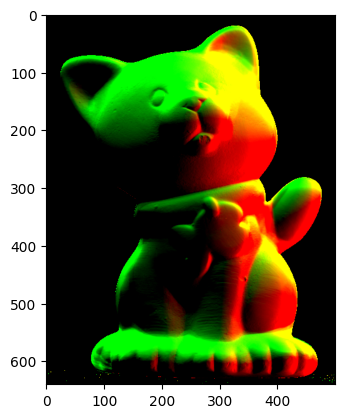

In [8]:
surf_norm = np.zeros([p.shape[0], p.shape[1], 3])
surf_norm[:, :, 0] = p
surf_norm[:, :, 1] = q
surf_norm[:, :, 2] = -1
plt.imshow(surf_norm)
plt.savefig("./Outputs/surface_normal.jpg")

## Frankot Chellappa

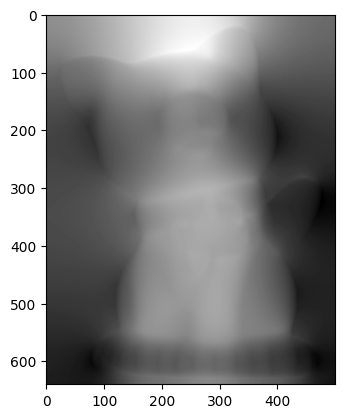

In [9]:
depth = frankotchellappa(p, q)

plt.imshow(depth.real, cmap='binary')
plt.savefig("./Outputs/depth_map.jpg")